In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.image as mpimg
import pyIGRF
%matplotlib inline

In [5]:
# Set the following parameters to determine which stations have "good" availability

syear = 1995  # Good stations will only be identified based on info between syear and eyear
eyear = 2019
'''Solar Maxima: 2002, 2014
   Solar Minima: 1997, 2009, 2020'''
low_lat = -90. # The minimum geographic latitude of stations to be considered
high_lat = 90. # The maximum geographic latitude of stations to be considered
w_lon = -180. # The minimum geographic longitude of stations to be considered
e_lon = 180. # The maximum geographic latitude of stations to be considered
avg_avail_min = 0 # Stations whose average percent available data over the years of consideration are less than this are eliminated
year_avail_min =0  # Stations that don't have at least this much available data every year are eliminated
all_stations_path = "supermag_table.csv" # The path to your raw SuperMAG data table
all_stations = pd.read_csv(all_stations_path)
all_stations["GLongg"] = all_stations["GLON"].apply(lambda x: x - 360 if x > 180 else x)

In [24]:
# Run the previous cell before running this one!



year_range = np.arange(syear, eyear+1)

if w_lon > e_lon:
    w_lon -= 360
    
# Select only the relevant years
all_cols = all_stations.columns.values
to_drop = []
for col_num in range(6, len(all_stations.iloc[1])):
    if int(all_cols[col_num]) not in year_range:
        to_drop.append(all_stations.columns[col_num])
all_stations = all_stations.drop(to_drop, axis=1)

# Select only the stations in the relevant region
outside_stations = []
for station in range(len(all_stations)):
    row = all_stations.iloc[station]
    if row["GLAT"] < low_lat or row["GLAT"] > high_lat or row["GLON"] < w_lon or row["GLON"] > e_lon:
        outside_stations.append(station)
geo_stations = all_stations.drop(outside_stations)

# Select only the stations with average availability >= avail_min
good_stations = pd.DataFrame([])
for row_num in range(len(geo_stations)):
    new_row = geo_stations.iloc[row_num][:6]
    pcts = []
    for col_num in range(6, len(geo_stations.iloc[1])):
        pct_str = geo_stations.iloc[row_num][col_num]
        pct = float(pct_str[:-1])
        pcts.append(pct)
    if np.sum(pcts) > avg_avail_min*(len(geo_stations.iloc[1])-6) and np.size(np.where(np.array(pcts)<year_avail_min)) == 0:
        new_row = pd.concat([new_row, pd.DataFrame(pcts)])
        good_stations = pd.concat([good_stations, new_row], axis=1, ignore_index=True)


print(good_stations.loc["IAGA"].values)
print(f"{len(good_stations.loc['IAGA'].values)} stations")

['SON' 'MEK' 'LOV' 'MAB' 'DOU' 'BFE' 'CLF' 'WNG' 'THY' 'BEL' 'FUR' 'NGK'
 'BDV' 'HYB' 'KMH' 'NMP' 'LON' 'SPG' 'ROE' 'NOR' 'NAL' 'LYR' 'HOP' 'BJN'
 'SOR' 'TRO' 'AND' 'JCK' 'DON' 'RVK' 'DOB' 'SOL' 'KAR' 'HRN' 'KEV' 'MAS'
 'KIL' 'IVA' 'ABK' 'LEK' 'MUO' 'LOZ' 'KIR' 'SOD' 'PEL' 'LYC' 'OUJ' 'HAN'
 'NUR' 'UPS' 'TAR' 'DIK' 'CCS' 'TIK' 'AAE' 'ABG' 'AMS' 'ASP' 'BMT' 'BNG'
 'CNB' 'CAN' 'CZT' 'DRV' 'EYR' 'GNA' 'GUA' 'HBK' 'HER' 'HLP' 'HRB' 'IRT'
 'ISK' 'KAK' 'LNP' 'MMB' 'NCK' 'PAF' 'PHU' 'SBA' 'SUA' 'TAM' 'TAN' 'KIV'
 'ODE' 'NVS' 'AAA' 'LVV' 'MOS' 'ZGN' 'YAK' 'PPI' 'BOX' 'MUT' 'PTN' 'LRM'
 'KAT' 'KTN' 'CHD' 'ZYK' 'MGD' 'MSR' 'ONW' 'KAG' 'CBI' 'YAP' 'BIK' 'WEW'
 'DRW' 'WEP' 'BSV' 'DAL' 'ADL' 'MCQ' 'AMD' 'VIZ' 'PBK' 'VOS' 'CSY' 'CTA'
 'DVS' 'HTY' 'KDU' 'KNY' 'MAW' 'TSU' 'AQU' 'LMM' 'LZH' 'QSB' 'TND' 'EBR'
 'LEM' 'RIK' 'BOR' 'KVI' 'S01' 'OUL' 'MCM' 'SPA' 'ELT' 'GZH' 'MLT' 'NOK'
 'TRP' 'BGY' 'ESA' 'GCK' 'KNZ' 'MIZ' 'BFO' 'B15' 'B19' 'B20' 'B21' 'B22'
 'B04' 'B05' 'B06' 'B07' 'B08' 'B09' 'B10' 'B24' 'B

In [7]:
180 -= 360

SyntaxError: 'literal' is an illegal expression for augmented assignment (3695611506.py, line 1)

In [42]:
all_stations.head()

,IAGA,GLON,GLAT,MLON,MLAT,Station name,2000,2001,2002,2003,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,SON,66.44,25.12,139.66,19.40,Sonmiani,0%,0%,0%,0%,...,0%,0%,0%,0%,13%,95%,91%,96%,82%,88%
1,AMU,210.13,61.24,-93.65,61.26,Anchorage,0%,0%,0%,0%,...,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%
2,YKC,245.52,62.48,-57.18,69.41,Yellowknife,99%,94%,100%,100%,...,98%,99%,100%,100%,99%,95%,100%,94%,80%,84%
3,CBB,254.97,69.12,-48.23,77.05,Cambridge Bay,99%,100%,99%,97%,...,95%,100%,100%,94%,93%,91%,97%,100%,92%,10%
4,RES,265.11,74.69,-36.09,82.95,Resolute Bay,100%,100%,100%,100%,...,100%,96%,100%,100%,100%,100%,100%,94%,98%,99%


-180.0


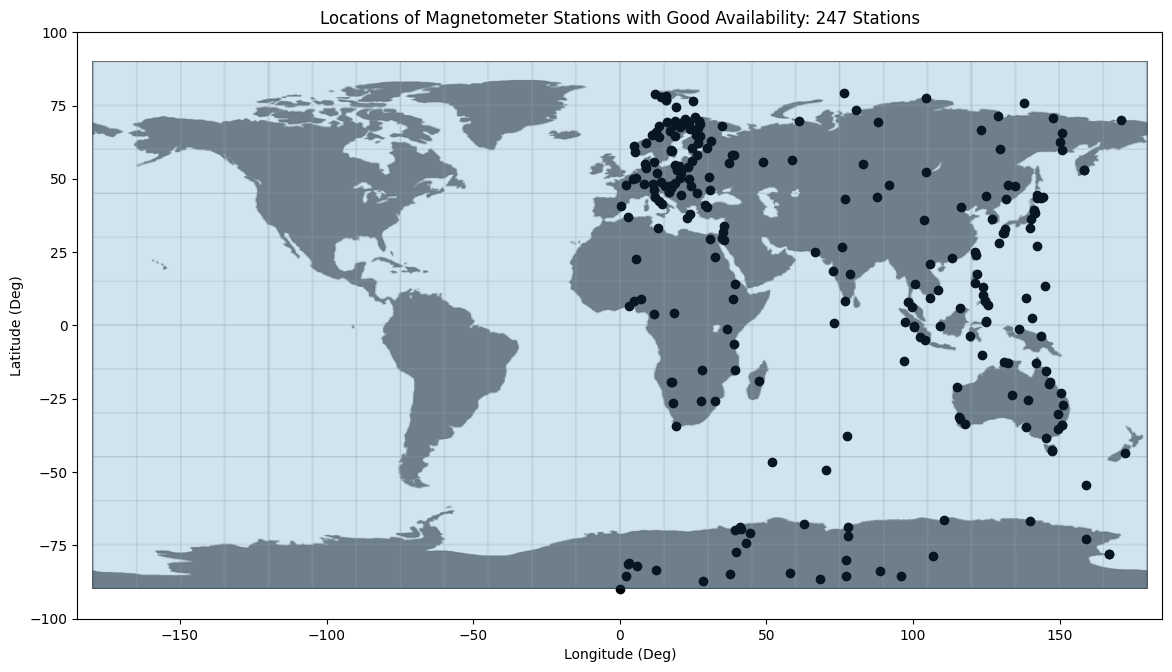

In [25]:
# Run the previous cells before running this one!

from matplotlib.patches import Rectangle

fig, ax = plt.subplots(figsize=(14,14))
img=mpimg.imread('world_map.jpg')
ax.imshow(img, extent=[-180,180,-90,90])

print(w_lon)
if w_lon >= 180:
    w_lon -= 360
    e_lon -= 360
    
lats = good_stations.loc["GLAT"].values
lons = good_stations.loc["GLON"].values
for i in range(len(lons)):
    if lons[i] >= 180:
        lons[i] -= 360

        
ax.scatter(lons, lats, c="Black")
ax.add_patch(Rectangle((w_lon, low_lat), e_lon-w_lon, high_lat-low_lat, alpha=0.2))
ax.set_xlim(w_lon-5,e_lon+5)
ax.set_ylim(low_lat-10, high_lat+10)
plt.xlabel("Longitude (Deg)")
plt.ylabel("Latitude (Deg)")
plt.title(f"Locations of Magnetometer Stations with Good Availability: {len(lats)} Stations")
plt.savefig("good_locs.png")

In [11]:
# @jit()
def calculateMag(xspace, yspace, year, height):
    euator = np.zeros((len(xspace), 2))
    inclination = np.zeros((len(yspace), len(xspace)))
    for x in range(len(xspace)):
        for y in range(len(yspace)):
            decl, inc, hMag, xMag, yMag, zMag, fMAg = pyIGRF.igrf_value(yspace[y], xspace[x], height, year)
            inclination[y,x] = inc



    
    equator = []
    for ii in range(inclination.shape[1]):
        
        temp = inclination[:,ii]

        sts = np.where((temp > -1) & (temp < 1))
        # print(sts)

        idx = sts[0][np.argmin(abs(temp[sts]))]


        equator.append(yspace[idx])    

    return inclination, equator

In [12]:
xspace = np.arange(-180,181,0.2)
yspace = np.arange(-20,20, 0.2)
incl, euator = calculateMag(xspace, yspace, 2022., 100)

In [13]:
high_lats = all_stations[(abs(all_stations["MLAT"])>=60) & (abs(all_stations["MLAT"])<90)]
mid_lats = all_stations[(abs(all_stations["MLAT"])>=30) & (abs(all_stations["MLAT"])<60)]
low_lats = all_stations[(abs(all_stations["MLAT"])>=0) & (abs(all_stations["MLAT"])<30)]


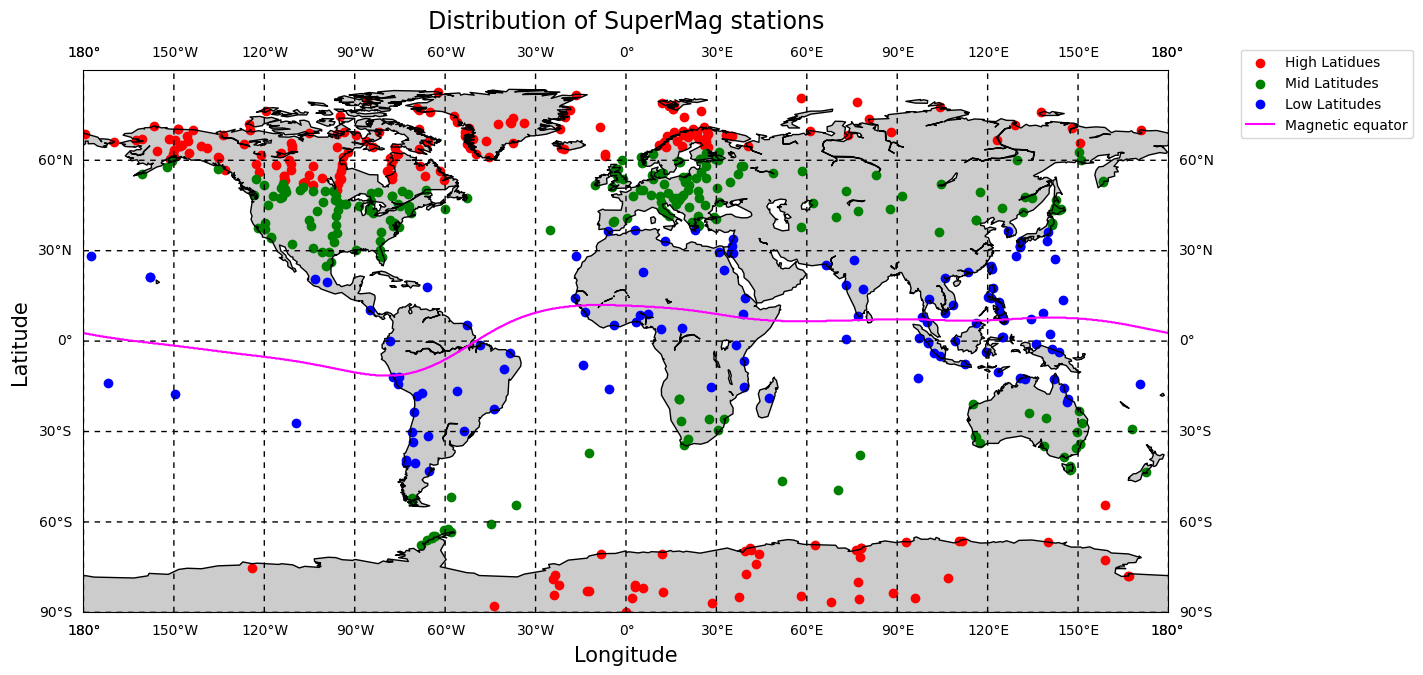

In [16]:
# Run the previous cells before running this one!
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Rectangle


fig, ax = plt.subplots(figsize=(14,14))
# img=mpimg.imread('world_map.jpg')
# ax.imshow(img, extent=[-180,180,-90,90])
m = Basemap()
m.drawcoastlines(linewidth=1.0, linestyle='solid', color='black')
m.fillcontinents()
m.drawmeridians(range(0, 360, 30), color='k', linewidth=1.0, dashes=[4, 4], labels=[0, 0, 1, 1])
m.drawparallels(range(-90, 90, 30), color='k', linewidth=1.0, dashes=[4, 4], labels=[1, 1, 0, 0])
# m.drawcountries()




# print(w_lon)
# if w_lon >= 180:
#     w_lon -= 360
#     e_lon -= 360

# for i in range(len(lons)):
#     if lons[i] >= 180:
#         lons[i] -= 360


# ax.scatter(all_stations["GLongg"].values, all_stations["GLAT"].values, c="red")
ax.scatter(high_lats["GLongg"].values, high_lats["GLAT"].values, c="red", label="High Latidues")
ax.scatter(mid_lats["GLongg"].values, mid_lats["GLAT"].values, c="green", label="Mid Latitudes")
ax.scatter(low_lats["GLongg"].values, low_lats["GLAT"].values, c="blue", label="Low Latitudes")
ax.plot(xspace,euator, color="magenta",label="Magnetic equator")

ax.legend(bbox_to_anchor=(1.06, 1.05))# ax.set_xlim(-180,180)
# ax.set_ylim(-90, 90)
plt.ylabel("Latitude", fontsize=15, labelpad=35)
plt.xlabel("Longitude", fontsize=15, labelpad=20)

# plt.xlabel("Longitude (Deg)")
# plt.ylabel("Latitude (Deg)")
plt.title(f"Distribution of SuperMag stations", fontsize=17, pad=30)
plt.savefig("good_locs.png")

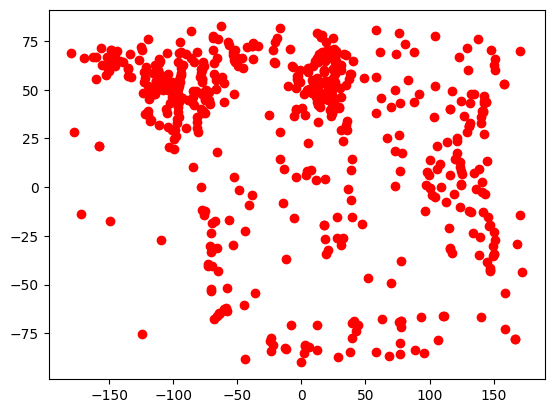

In [9]:
plt.scatter(all_stations["GLongg"].values, all_stations["GLAT"].values, c="red")

In [5]:
all_stations["GLON"].values

array([ 66.44, 210.13, 245.52, 254.97, 265.11, 263.99, 246.65, 224.67,
       282.26,  30.97, 307.32, 297.5 , 338.3 , 254.76, 240.28, 236.58,
       242.88,  17.83, 358.82, 349.75, 355.52, 356.8 ,   5.68,   4.6 ,
        11.67,   2.27, 284.45,   9.07, 292.38, 354.27, 334.87, 303.83,
        17.54,  20.8 ,  11.28,  12.68,  14.02, 282.63, 275.09,  78.6 ,
       250.58,  18.11,  39.25, 211.21, 323.51, 256.3 , 235.83,  16.66,
        29.72, 291.18,   8.55, 290.77, 294.9 , 302.82, 303.85, 307.87,
       306.47, 306.43, 309.28, 307.1 , 308.27, 310.32, 314.56, 343.33,
       341.37, 339.78, 338.03, 322.37, 322.38, 326.1 , 317.41, 321.65,
       313.71, 347.69, 321.7 , 353.2 , 265.36, 266.45, 248.75, 220.89,
       265.95, 265.91, 248.79, 238.77, 248.07, 265.34, 263.96, 256.32,
       267.89,  25.79,  11.95,  15.83, 351.3 ,  25.01,  19.2 ,  22.22,
        18.94,  16.03,  16.98,  12.5 ,  10.99,   9.11,   4.84,   5.24,
        15.6 ,  22.96,  27.01,  23.7 ,  20.77,  23.05,  27.29,  18.82,
      

In [97]:
pixel_size = 2

lng_1darray = np.arange(0, 360, pixel_size)
lat_1darray = np.arange(180, 0, -pixel_size)

lngs, lats = np.meshgrid(lng_1darray, lat_1darray)

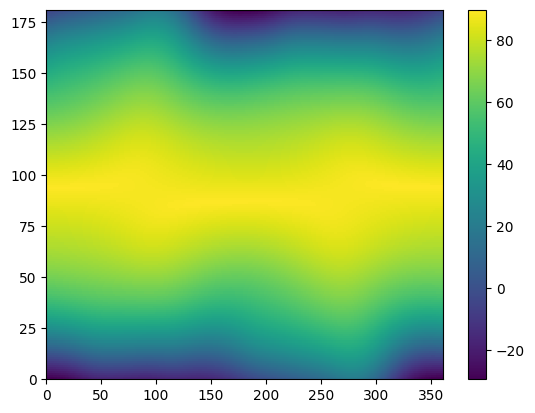

In [94]:
plt.pcolormesh(np.transpose(incl[0]))
plt.colorbar()